In [1]:
%matplotlib inline

In [2]:
import gc
import pathlib

In [3]:
import joblib
import lightgbm as lgb
import pandas as pd

In [4]:
root_dir_path = pathlib.Path("..")
data_dir_path = root_dir_path / "data"
processed_dir_path = data_dir_path / "processed"
train_path = processed_dir_path / "train_filtered.parquet"
models_dir_path = root_dir_path / "models"
model_path = models_dir_path / "model.joblib"

In [5]:
calendar_features = [
    "year",
    "dayofyear",
    "weekofyear",
    "quarter",
    "month",
    "day",
    "weekday",
    "is_year_start",
    "is_year_end",
    "is_month_start",
    "is_month_end",
]
lag_features = [f"demand_shift_{i}" for i in range(28, 29)]
categorical_features = [
    "store_id",
    "item_id",
    "dept_id",
    "cat_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
]
numerical_features = [
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
] + calendar_features + lag_features
features = categorical_features + numerical_features

In [6]:
train = pd.read_parquet(train_path)

In [7]:
is_train = train["date"] <= "2016-01-28"
train, valid = train[is_train], train[~is_train]

In [8]:
del is_train

In [9]:
gc.collect()

0

In [10]:
train.shape

(43375450, 30)

In [11]:
valid.shape

(2652507, 30)

In [12]:
X = train[features]
X_valid = valid[features]
y = train["demand"]
y_valid = valid["demand"]

In [13]:
del train
del valid

In [14]:
gc.collect()

0

In [15]:
model = lgb.LGBMRegressor(importance_type="gain", random_state=0)

In [16]:
model.fit(X, y, categorical_feature=categorical_features, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)])

C:\Users\Yu Ohori\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's l2: 12.0775
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 11.0185
[3]	valid_0's l2: 10.1569
[4]	valid_0's l2: 9.44273
[5]	valid_0's l2: 8.88238
[6]	valid_0's l2: 8.39826
[7]	valid_0's l2: 8.00638
[8]	valid_0's l2: 7.6832
[9]	valid_0's l2: 7.42628
[10]	valid_0's l2: 7.20609
[11]	valid_0's l2: 7.03176
[12]	valid_0's l2: 6.87704
[13]	valid_0's l2: 6.73791
[14]	valid_0's l2: 6.6317
[15]	valid_0's l2: 6.54133
[16]	valid_0's l2: 6.45991
[17]	valid_0's l2: 6.41842
[18]	valid_0's l2: 6.35431
[19]	valid_0's l2: 6.28738
[20]	valid_0's l2: 6.22319
[21]	valid_0's l2: 6.17738
[22]	valid_0's l2: 6.13671
[23]	valid_0's l2: 6.10343
[24]	valid_0's l2: 6.08042
[25]	valid_0's l2: 6.06369
[26]	valid_0's l2: 6.04484
[27]	valid_0's l2: 6.02186
[28]	valid_0's l2: 6.02133
[29]	valid_0's l2: 6.00778
[30]	valid_0's l2: 5.98006
[31]	valid_0's l2: 5.96354
[32]	valid_0's l2: 5.97643
[33]	valid_0's l2: 5.96206
[34]	valid_0's l2: 5.94809
[35]	valid_0's l2: 5.9412
[36]	v

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

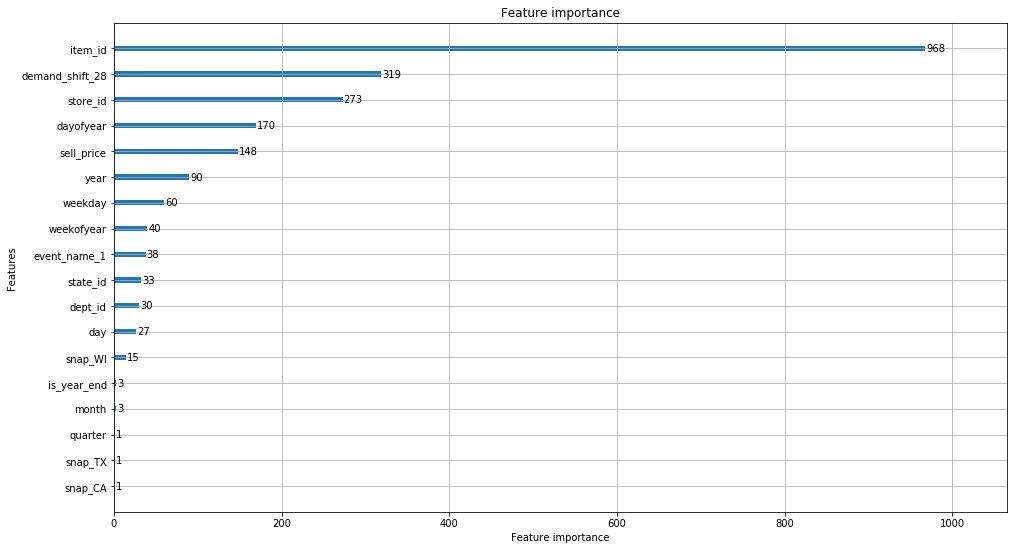

In [17]:
ax = lgb.plot_importance(model, figsize=(16, 9))

In [18]:
joblib.dump(model, model_path)

['..\\models\\model.joblib']